# 🏗️Import Necessary Libraries

In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# 🤙Create helper functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-06-11 20:36:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-11 20:36:51 (54.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 📥Load and Transform Data

In [4]:
BATCH_SIZE = 256
IMAGE_SIZE = (224, 224)

In [5]:
# Walk through each directory
dataset = "/kaggle/input/realifake/Realifake"
walk_through_dir(dataset)

There are 2 directories and 0 images in '/kaggle/input/realifake/Realifake'.
There are 0 directories and 82434 images in '/kaggle/input/realifake/Realifake/FAKE'.
There are 0 directories and 91993 images in '/kaggle/input/realifake/Realifake/REAL'.


In [6]:
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     dataset,
#     validation_split=0.4,
#     subset="training",
#     seed=123,
#     image_size=IMAGE_SIZE,
#     batch_size=BATCH_SIZE


In [7]:
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     dataset,
#     validation_split=0.4,
#     subset="validation",
#     seed=123,
#     image_size=IMAGE_SIZE,
#     batch_size=BATCH_SIZE


In [8]:
# Check class names
#class_names = train_ds.class_names
#print(class_names)

In [9]:
# test_ds = val_ds.take(int(len(val_ds) * 0.5))
# val_ds = val_ds.skip(int(len(val_ds) * 0.5))

# 📅Placing data into a Dataframe
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [10]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [11]:
len(list(image_dir.glob(r'**/*.jpg')))

174084

In [12]:
image_df.head(100)

,Filepath,Label
0,/kaggle/input/realifake/Realifake/REAL/real_50...,REAL
1,/kaggle/input/realifake/Realifake/REAL/real_61...,REAL
2,/kaggle/input/realifake/Realifake/REAL/real_35...,REAL
3,/kaggle/input/realifake/Realifake/REAL/real_26...,REAL
4,/kaggle/input/realifake/Realifake/REAL/real_21...,REAL
...,...,...
95,/kaggle/input/realifake/Realifake/FAKE/fake_21...,FAKE
96,/kaggle/input/realifake/Realifake/FAKE/fake_78...,FAKE
97,/kaggle/input/realifake/Realifake/FAKE/fake_13...,FAKE
98,/kaggle/input/realifake/Realifake/FAKE/fake_43...,FAKE


# 🔭Visualizing images from the dataset

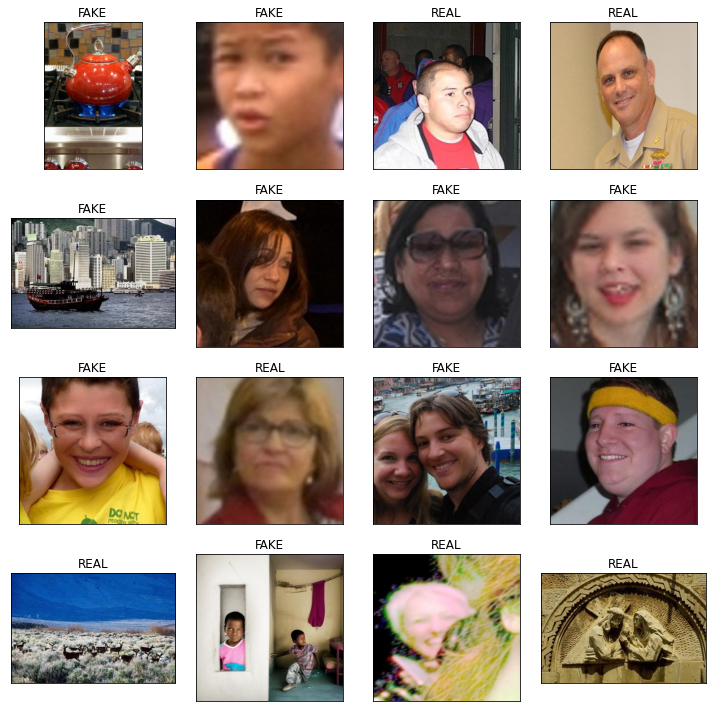

In [13]:
import matplotlib.image as mpimg
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# 📝Data Preprocessing
The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [18]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [19]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.4
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [20]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=256,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=256,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=256,
    shuffle=False
)

Found 83605 validated image filenames belonging to 2 classes.
Found 55736 validated image filenames belonging to 2 classes.
Found 34836 validated image filenames belonging to 2 classes.


In [21]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# 🤹Training the model
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

**Batch size** : 256

**Epochs** : 15

**Input Shape** : (224, 224, 3)

**Output layer** : 1



In [22]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [23]:
# Create checkpoint callback
checkpoint_path = "image_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [24]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 20,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

# 🚄Training the model

In [25]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=15,
    callbacks=[
        early_stopping,
        
    ]
)

Epoch 1/15
327/327 [==============================] - 1459s 4s/step - loss: 0.5535 - accuracy: 0.7088 - val_loss: 0.4855 - val_accuracy: 0.7592
Epoch 2/15
327/327 [==============================] - 619s 2s/step - loss: 0.4857 - accuracy: 0.7583 - val_loss: 0.4621 - val_accuracy: 0.7726
Epoch 3/15
327/327 [==============================] - 558s 2s/step - loss: 0.4611 - accuracy: 0.7744 - val_loss: 0.4548 - val_accuracy: 0.7763
Epoch 4/15
327/327 [==============================] - 560s 2s/step - loss: 0.4444 - accuracy: 0.7839 - val_loss: 0.4418 - val_accuracy: 0.7834
Epoch 5/15
327/327 [==============================] - 562s 2s/step - loss: 0.4286 - accuracy: 0.7942 - val_loss: 0.4337 - val_accuracy: 0.7883
Epoch 6/15
327/327 [==============================] - 578s 2s/step - loss: 0.4151 - accuracy: 0.8015 - val_loss: 0.4284 - val_accuracy: 0.7917
Epoch 7/15
327/327 [==============================] - 599s 2s/step - loss: 0.4020 - accuracy: 0.8099 - val_loss: 0.4263 - val_accuracy: 0.792

# ✔️Model Evaluation
The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:

**Precision(P)**: 
The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.

<center>$P=TP/(TP+FP)$</center>

**Recall(R)**: 
The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.
<center>$R=TP/(TP+FN)$</center>

**F1 score(F1)**: 
The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.
<center>$F1=2 * (TP * FP)/(TP+FP)$</center>



In [26]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.43893
Test Accuracy: 79.96%


# 📉Visualizing loss curves

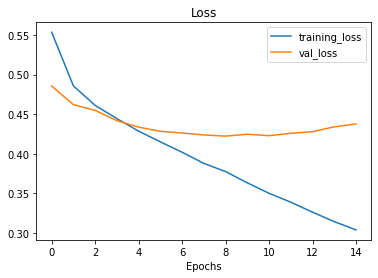

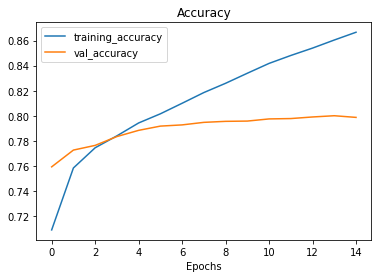

In [27]:
plot_loss_curves(history)

# 🔮Making predictions on the Test Data

In [28]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['REAL', 'FAKE', 'FAKE', 'FAKE', 'REAL']


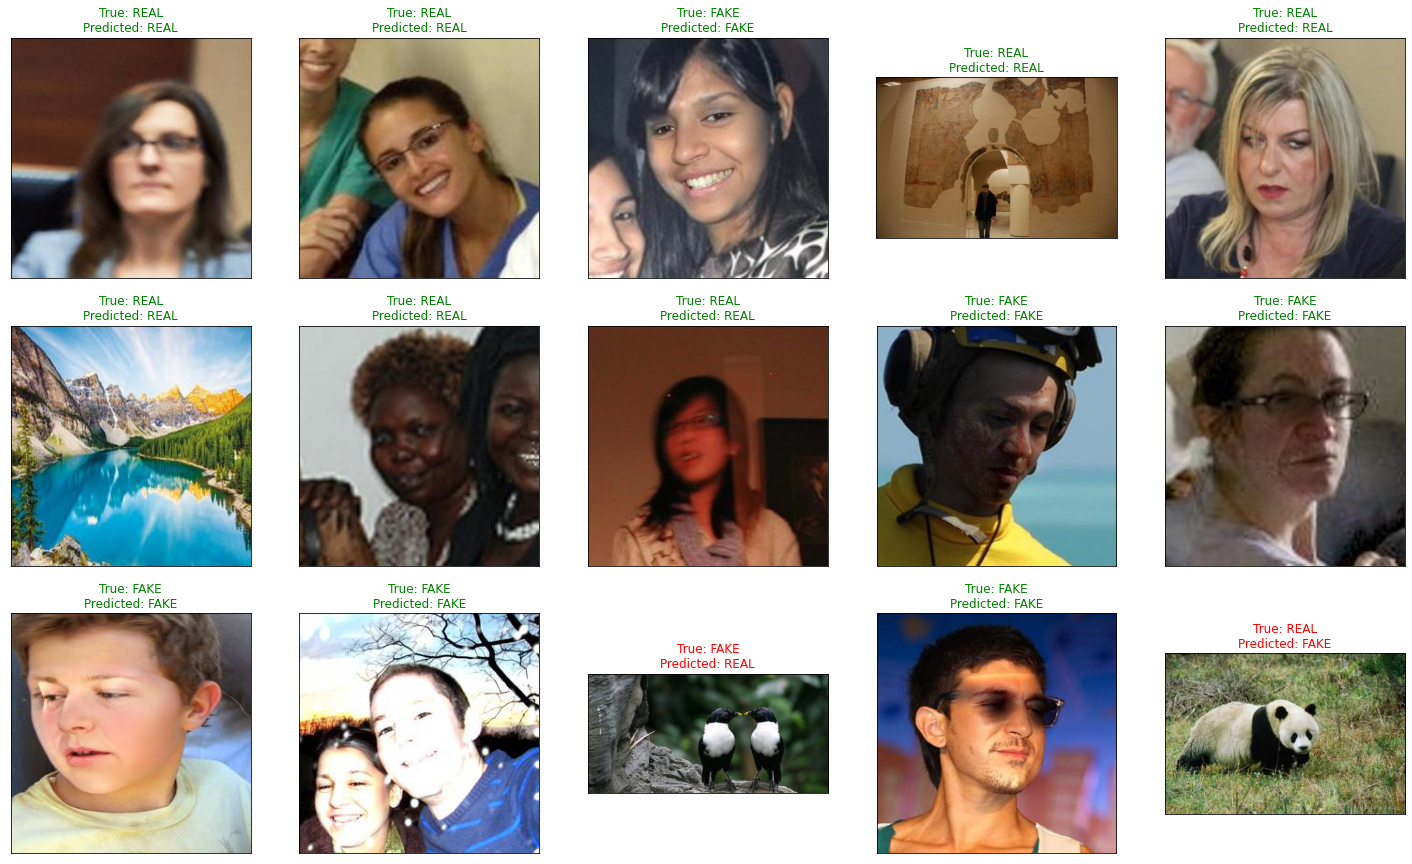

<Figure size 432x288 with 0 Axes>

In [29]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 📊Plotting the Classification Reports and Confusion Matrix

In [30]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        FAKE       0.79      0.79      0.79     16427
        REAL       0.81      0.81      0.81     18409

    accuracy                           0.80     34836
   macro avg       0.80      0.80      0.80     34836
weighted avg       0.80      0.80      0.80     34836



In [31]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
FAKE,0.788304,0.786145,0.787223,16427.000000
REAL,0.809635,0.811614,0.810623,18409.000000
accuracy,0.799604,0.799604,0.799604,0.799604
macro avg,0.798970,0.798879,0.798923,34836.000000
weighted avg,0.799576,0.799604,0.799589,34836.000000


In [32]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False): 
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """  
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


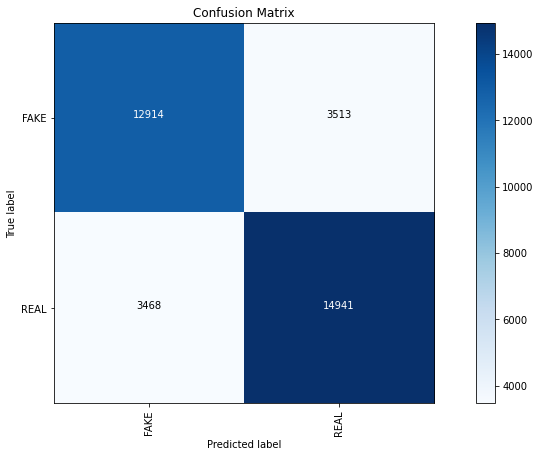

In [33]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [35]:
tf.saved_model.save(model, "/kaggle/working/")
converter = tf.lite.TFLiteConverter.from_saved_model("/kaggle/working/")
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

10436308

### Thanks for viewing the notebook. I would greatly appreciate any feedback, suggestions and recommendations for improvement. Cheers! 

<center><img src='https://media4.giphy.com/media/M9gbBd9nbDrOTu1Mqx/giphy.gif?cid=790b7611704aa2ca4e403287801480a6c753abf45f3e6242&rid=giphy.gif&ct=s' 
     height=30px width=160px /></center>